# Requirements
For this tutorial, you will need `python >= 3.9`.

Make sure to install `spatialdata_io >= 0.0.9` and `spatialdata_xenium_explorer >= 0.1.5`, i.e.:
```sh
pip install spatialdata-io
pip install spatialdata_xenium_explorer
```

In [1]:
import spatialdata_io
import spatialdata_xenium_explorer

# 1. Download tutorial data

This tutorial is based on a Xenium sample of human skin, which can be downloaded on this [10x Genomics webpage](https://www.10xgenomics.com/datasets/human-skin-preview-data-xenium-human-skin-gene-expression-panel-add-on-1-standard).
In particular, download the following directory/file:
- [Xenium Output Bundle (full)](https://cf.10xgenomics.com/samples/xenium/1.7.0/Xeniumranger_V1_hSkin_Melanoma_Add_on_FFPE/Xeniumranger_V1_hSkin_Melanoma_Add_on_FFPE_outs.zip) (unzip it into a directory)
- [Supplemental: Post-Xenium H&E image (OME-TIFF)](https://cf.10xgenomics.com/samples/xenium/1.7.0/Xeniumranger_V1_hSkin_Melanoma_Add_on_FFPE/Xeniumranger_V1_hSkin_Melanoma_Add_on_FFPE_he_image.ome.tif) (move it into the latter directory)

# 2. Read the Xenium data

In [2]:
# directory containing the Xenium data you downloaded
data_path = "Xeniumranger_V1_hSkin_Melanoma_Add_on_FFPE_outs"

The Xenium data can be read by `spatialdata-io`:

In [3]:
sdata = spatialdata_io.xenium(data_path)

INFO     reading Xeniumranger_V1_hSkin_Melanoma_Add_on_FFPE_outs/cell_feature_matrix.h5                            


/Users/quentinblampey/Library/Caches/pypoetry/virtualenvs/spatialdata-xenium-explorer-yAxRBYoR-py3.9/lib/python3.9/site-packages/spatialdata/models/models.py:725: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[region_key]):
/Users/quentinblampey/Library/Caches/pypoetry/virtualenvs/spatialdata-xenium-explorer-yAxRBYoR-py3.9/lib/python3.9/site-packages/spatialdata_io/readers/xenium.py:197: UserWarning: Converting `region_key: region` to categorical dtype.
  table = TableModel.parse(adata, region=specs["region"], region_key="region", instance_key=str(XeniumKeys.CELL_ID))
/Users/quentinblampey/Library/Caches/pypoetry/virtualenvs/spatialdata-xenium-explorer-yAxRBYoR-py3.9/lib/python3.9/site-packages/spatialdata/models/models.py:620: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype)

In [4]:
sdata

SpatialData object with:
├── Images
│     ├── 'morphology_focus': MultiscaleSpatialImage[cyx] (1, 13725, 28467), (1, 6862, 14233), (1, 3431, 7116), (1, 1715, 3558), (1, 857, 1779)
│     └── 'morphology_mip': MultiscaleSpatialImage[cyx] (1, 13725, 28467), (1, 6862, 14233), (1, 3431, 7116), (1, 1715, 3558), (1, 857, 1779)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 10) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (87499, 1) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (87499, 1) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 87499 × 382
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial': AnnData (87499, 382)
with coordinate systems:
▸ 'global', with

# 3. Image alignment

### Alignment from the Xenium Explorer to `SpatialData`

First, select "Add Image" under the "Images" panel:

<img src="assets/xenium/alignment_1.png" alt="image" width="800" height="auto">

Then, select the H&E image, i.e. the file called `Xeniumranger_V1_hSkin_Melanoma_Add_on_FFPE_he_image.ome.tif`:

<img src="assets/xenium/alignment_2.png" alt="image" width="800" height="auto">

Then, click on "No, image is not aligned", and follow the instructions.

<img src="assets/xenium/alignment_3.png" alt="image" width="800" height="auto">

Afterwards, the H&E image is aligned, and you can now superpose your cells:

<img src="assets/xenium/alignment_4.png" alt="image" width="800" height="auto">

#### Update the `SpatialData` object

We can use the transformation from the Xenium Explorer to update the `SpatialData` object. For this, first export the transformation matrix as below:

<img src="assets/xenium/alignment_5.png" alt="image" width="800" height="auto">

Then, we will open the H&E tif image

In [5]:
from spatialdata_xenium_explorer.core.images import ome_tif
from pathlib import Path

In [6]:
he_image = ome_tif(Path(data_path) / "Xeniumranger_V1_hSkin_Melanoma_Add_on_FFPE_he_image.ome.tif")

[INFO] (spatialdata_xenium_explorer.core.images) Transformed 4D image into a 3D image of shape (c, y, x) = (3, 43287, 22209)
[WARNING] (spatialdata_xenium_explorer.core.images) Channel names couldn't be read. Using ['0', '1', '2'] instead.


In [ ]:
image_key = "morphology_mip"

# where you exported the alignment file
alignment_matrix_path = "Xeniumranger_V1_hSkin_Melanoma_Add_on_FFPE_he_imagealignment.csv"

spatialdata_xenium_explorer.align(sdata, he_image, alignment_matrix_path, image_key=image_key)

In [9]:
sdata

SpatialData object with:
├── Images
│     ├── 'Xeniumranger_V1_hSkin_Melanoma_Add_on_FFPE_he_image': SpatialImage[cyx] (3, 43287, 22209)
│     ├── 'morphology_focus': MultiscaleSpatialImage[cyx] (1, 13725, 28467), (1, 6862, 14233), (1, 3431, 7116), (1, 1715, 3558), (1, 857, 1779)
│     └── 'morphology_mip': MultiscaleSpatialImage[cyx] (1, 13725, 28467), (1, 6862, 14233), (1, 3431, 7116), (1, 1715, 3558), (1, 857, 1779)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 10) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (87499, 1) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (87499, 1) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 87499 × 382
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 's

### Alignment from `SpatialData` to the Xenium Explorer

Now, we suppose you have already aligned your H&E image using `SpatialData`. Here, we detail how use the transformation inside the Xenium Explorer.

In [24]:
from spatialdata.transformations import get_transformation, Affine
import numpy as np

First, we get the transformation from the H&E image to the global coordinate system:

In [29]:
spatial_element = sdata["Xeniumranger_V1_hSkin_Melanoma_Add_on_FFPE_he_image"]

transformation = get_transformation(spatial_element, to_coordinate_system="global")

If it is an affine transformation, we can create a `.csv` file representing the transformation:

In [30]:
assert isinstance(
    transformation, Affine
), "The Xenium Explorer only supports Affine transformations"

np.savetxt("alignment_matrix.csv", transformation.matrix, delimiter=",")

Now, when adding a new image in the Xenium Explorer, select "Yes, use an existing alignment file", and upload the `alignment_matrix.csv` file that you just created.

<img src="assets/xenium/from_spatialdata.png" alt="image" width="800" height="auto">

# 4. Update the cells on the Explorer

### Update the cell categories

Here, we run some Leiden clustering with `scanpy`. Then, we will update the Xenium Explorer files to display the spot clusters.

More generally, you can add new cell categories, i.e. a column of `sdata.table.obs`, and the Xenium Explorer will show it after the instructions below.

> Note that we only display categorical columns. If a column from `sdata.table.obs` contains continuous numerical values (e.g., `3.13, 7.89, ...`), it will not be transformed into a categorical variable, and therefore not shown in the Xenium Explorer. In this case, we recommend using `spatiadata_plot` as shown above.

In [ ]:
import scanpy as sc

sc.pp.normalize_total(sdata.table)
sc.pp.log1p(sdata.table)
sc.pp.pca(sdata.table)
sc.pp.neighbors(sdata.table)
sc.tl.leiden(sdata.table)

In [60]:
sc.tl.leiden(sdata.table)

Now, you can update the explorer with your new cluster assignment. You don't need to re-run the complete conversion; you can edit the `analysis.zarr.zip` file only, as below.

> Alternatively, you can use the `spatialdata_xenium_explorer` CLI instead of the API, as detailed [here](https://quentinblampey.github.io/spatialdata_xenium_explorer/cli/#update-obs).

In [61]:
spatialdata_xenium_explorer.write_cell_categories(data_path, sdata.table)

[INFO] (spatialdata_xenium_explorer.core.table) Writing 3 cell categories: region, lasso, leiden


To visualize these clusters, re-open the `experiment.xenium` file and select the new `"leiden"` cell group (under the "Cells" panel and in the "Cell groups" dropdown). See the examples above to see how it looks on the Xenium Explorer.

<img src="assets/xenium/leiden.png" alt="image" width="800" height="auto">

### Update a new segmentation

In the case where you performed your own segmentation, you may want to update the explorer with  your new cells. You'll also need to update `sdata.table` to contain the transcript counts associated to your new cells.

> Note that `mode="-it"` signifies to create all files except the image and transcript file. Indeed, the two latter files doesn't need to be updated, they will remain the same.

In [57]:
import spatialdata

In [ ]:
# this is the key related to your new cell boundaries, i.e. sdata[shapes_key] is a pandas GeoDataFrame
shapes_key = "new_shapes"

Now, update all the files related to your new cells:

In [ ]:
spatialdata_xenium_explorer.write(data_path, sdata, image_key=image_key, shapes_key=shapes_key, mode="-it")

# 5. Select cells from the lasso tool

On the Xenium Explorer, use the Lasso tool to select some spots of interest. Then, click on "Download Cell Stats as CSV", as below. It will create a file called `"Selection_1_cells_stats.csv"`.

<img src="assets/xenium/lasso.png" alt="image" width="800" height="auto">

In [55]:
import pandas as pd
import numpy as np
import scanpy as sc

# add the path to the file that you downloaded, e.g. "Selection_1_cells_stats.csv"
df_selection = pd.read_csv("Selection_2_cells_stats.csv", skiprows=2)

# this line converts the Xenium spot ID into a spot index
spot_indices = df_selection["Cell ID"].map(spatialdata_xenium_explorer.utils.int_cell_id).values

sdata.table.obs["lasso"] = pd.Categorical(
    np.where(sdata.table.obs["cell_id"].isin(df_selection["Cell ID"].values), "selected", "not-selected")
)

Now, `sdata.table.obs["lasso"]` denotes which cells have been selected by the lasso tool (either "selected" or "not-selected").

We can then use `spatialdata_plot` to display the cells that were selected by the lasso tool. Make sure to install `spatialdata_plot >= 0.1.0`, e.g. via `pip install spatialdata_plot`. Now, we can render the shapes (i.e., the spots) and colour them based on the `"lasso"` column that was saved in `sdata.table.obs`:

In [33]:
import spatialdata_plot

/Users/quentinblampey/Library/Caches/pypoetry/virtualenvs/spatialdata-xenium-explorer-yAxRBYoR-py3.9/lib/python3.9/site-packages/spatialdata/models/models.py:466: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(data[feature_key]):
/Users/quentinblampey/Library/Caches/pypoetry/virtualenvs/spatialdata-xenium-explorer-yAxRBYoR-py3.9/lib/python3.9/site-packages/spatialdata/models/models.py:466: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(data[feature_key]):
/Users/quentinblampey/Library/Caches/pypoetry/virtualenvs/spatialdata-xenium-explorer-yAxRBYoR-py3.9/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users

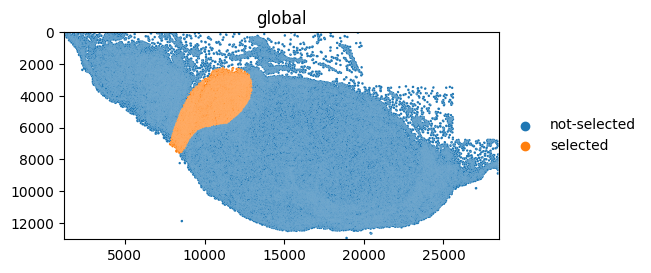

In [56]:
sdata.pl.render_shapes("cell_boundaries", color="lasso").pl.show("global")